## Import Data and Libraries

In [1]:
!git clone https://github.com/laura-health/cbms2020/
!pip install catboost
!pip install lightgbm
!pip install missingpy

Cloning into 'cbms2020'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 32 (delta 12), reused 7 (delta 2), pack-reused 0
Unpacking objects: 100% (32/32), done.


## Load Data and Libraries

In [2]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
#from missingpy import MissForest
#import missingpy
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, f1_score
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')

#new imports
import matplotlib.pyplot as plt
import seaborn as sns 
import pandas as pd

In [3]:
dataset = pd.read_csv("heg_sample_data.csv") #normalized dataset
dataset.drop('Unnamed: 0', axis=1, inplace=True)
dataset.shape, dataset.columns

((13652, 72),
 Index(['days_from_entrance', 'age', 'document.sexo', 'UTI',
        'delta_collect_timestamp_t-t1', 'delta_collect_timestamp_t1-t2',
        'delta_collect_timestamp_t2-t3', 'delta_collect_timestamp_t3-t4',
        'document.freq_cardiaca(t)', 'document.freq_cardiaca(t-1)',
        'document.freq_cardiaca(t-2)', 'document.freq_cardiaca(t-3)',
        'document.freq_cardiaca(t-4)', 'document.freq_respiratoria(t)',
        'document.freq_respiratoria(t-1)', 'document.freq_respiratoria(t-2)',
        'document.freq_respiratoria(t-3)', 'document.freq_respiratoria(t-4)',
        'document.glicemia_capilar(t)', 'document.glicemia_capilar(t-1)',
        'document.glicemia_capilar(t-2)', 'document.glicemia_capilar(t-3)',
        'document.glicemia_capilar(t-4)', 'document.pa_diastolica(t)',
        'document.pa_diastolica(t-1)', 'document.pa_diastolica(t-2)',
        'document.pa_diastolica(t-3)', 'document.pa_diastolica(t-4)',
        'document.pa_sistolica(t)', 'document.pa_si

In [35]:
dataset.head()

,days_from_entrance,age,document.sexo,UTI,delta_collect_timestamp_t-t1,delta_collect_timestamp_t1-t2,delta_collect_timestamp_t2-t3,delta_collect_timestamp_t3-t4,document.freq_cardiaca(t),document.freq_cardiaca(t-1),...,delta_document.pa_sistolica_t3-t4,delta_document.sat_o2_t-t1,delta_document.sat_o2_t1-t2,delta_document.sat_o2_t2-t3,delta_document.sat_o2_t3-t4,delta_document.temperatura_t-t1,delta_document.temperatura_t1-t2,delta_document.temperatura_t2-t3,delta_document.temperatura_t3-t4,outcome
0,0.481160,-0.430375,1.0,0.0,0.181480,0.282895,0.397339,0.387741,-0.130331,0.337252,...,0.107772,0.202479,0.194332,0.432788,0.012866,-0.144525,-0.024481,0.152412,0.007067,0.0
1,1.837695,0.230175,1.0,0.0,1.201338,1.826415,1.625187,2.170093,1.451289,1.601233,...,-0.021933,0.060615,0.114810,0.672236,-1.299337,-0.144525,-0.024481,0.152412,0.007067,0.0
2,0.226810,-0.719366,1.0,0.0,2.049497,4.031576,1.846655,2.285346,0.301020,0.403377,...,0.139667,0.060615,0.114810,0.672236,-1.299337,-0.144525,-0.024481,0.152412,0.007067,0.0
3,-0.366674,1.716413,1.0,0.0,1.038056,0.686616,1.107306,0.877358,0.684443,0.823398,...,-0.101163,0.060615,0.114810,0.672236,-1.299337,-0.144525,-0.024481,0.152412,0.007067,0.0
4,-0.366674,1.262285,0.0,0.0,0.879474,0.416499,0.427891,0.405360,0.492732,-0.537812,...,-0.021933,0.060615,0.114810,0.672236,-1.299337,-0.144525,-0.024481,0.152412,0.007067,1.0


In [36]:
dataset.info 

<bound method DataFrame.info of        days_from_entrance       age  document.sexo  UTI  \
0                0.481160 -0.430375            1.0  0.0   
1                1.837695  0.230175            1.0  0.0   
2                0.226810 -0.719366            1.0  0.0   
3               -0.366674  1.716413            1.0  0.0   
4               -0.366674  1.262285            0.0  0.0   
...                   ...       ...            ...  ...   
13647           -0.281891  0.643019            1.0  0.0   
13648            0.142026  1.097147            0.0  0.0   
13649           -0.281891  0.106322            0.0  0.0   
13650           -0.281891  1.386138            1.0  0.0   
13651           -0.027540  1.179716            1.0  0.0   

       delta_collect_timestamp_t-t1  delta_collect_timestamp_t1-t2  \
0                          0.181480                       0.282895   
1                          1.201338                       1.826415   
2                          2.049497              

In [37]:
dataset.describe()

,days_from_entrance,age,document.sexo,UTI,delta_collect_timestamp_t-t1,delta_collect_timestamp_t1-t2,delta_collect_timestamp_t2-t3,delta_collect_timestamp_t3-t4,document.freq_cardiaca(t),document.freq_cardiaca(t-1),...,delta_document.pa_sistolica_t3-t4,delta_document.sat_o2_t-t1,delta_document.sat_o2_t1-t2,delta_document.sat_o2_t2-t3,delta_document.sat_o2_t3-t4,delta_document.temperatura_t-t1,delta_document.temperatura_t1-t2,delta_document.temperatura_t2-t3,delta_document.temperatura_t3-t4,outcome
count,13652.000000,13652.000000,13652.000000,13652.000000,13652.000000,13652.000000,13652.000000,13652.000000,13652.000000,13652.000000,...,13652.000000,13652.000000,13652.000000,13652.000000,13652.000000,13652.000000,13652.000000,13652.000000,13652.000000,13652.000000
mean,0.399184,0.463245,0.494067,0.020876,0.992096,1.081193,1.055485,1.032935,0.018090,0.045441,...,0.053870,0.041518,0.073749,0.215126,-0.379429,-0.096299,-0.016314,0.082699,0.005842,0.123205
std,1.439455,0.764911,0.499983,0.142975,2.071101,2.138497,2.018020,1.862388,0.814088,0.829313,...,0.937886,0.991931,0.991343,1.020810,1.079922,0.756354,0.781680,0.726609,0.708858,0.328685
min,-0.451458,-1.834045,0.000000,0.000000,-0.473344,-0.451416,-0.465123,-0.484732,-3.149786,-3.163003,...,-8.443574,-18.360347,-17.468245,-14.512921,-15.840279,-5.643138,-7.585503,-5.775955,-7.405789,0.000000
25%,-0.281891,0.065038,0.000000,0.000000,0.142114,0.223989,0.319097,0.353060,-0.513754,-0.489197,...,-0.028585,0.004101,-0.002062,-0.001954,-1.299337,-0.144525,-0.024481,0.012286,0.006474,0.000000
50%,-0.112324,0.601735,0.000000,0.000000,0.286479,0.311889,0.404968,0.390850,-0.034475,-0.003051,...,0.099724,0.060615,0.114810,0.424839,0.011498,-0.144525,-0.024481,0.152412,0.007067,0.000000
75%,0.311593,1.014579,1.000000,0.000000,0.947662,0.988167,1.344691,1.410752,0.492732,0.483096,...,0.139667,0.202479,0.194332,0.672236,0.012866,0.043144,0.022505,0.152412,0.007067,0.000000
max,30.664055,2.294395,1.000000,1.000000,48.176757,54.180924,52.875288,47.886087,5.525157,8.212825,...,8.431205,17.552352,12.889645,14.082220,18.433833,5.404496,7.159047,5.460043,7.229116,1.000000


In [4]:
#list = list(dataset)
#list = dataset.columns.values.tolist()
print(dataset.columns.values)

['days_from_entrance' 'age' 'document.sexo' 'UTI'
 'delta_collect_timestamp_t-t1' 'delta_collect_timestamp_t1-t2'
 'delta_collect_timestamp_t2-t3' 'delta_collect_timestamp_t3-t4'
 'document.freq_cardiaca(t)' 'document.freq_cardiaca(t-1)'
 'document.freq_cardiaca(t-2)' 'document.freq_cardiaca(t-3)'
 'document.freq_cardiaca(t-4)' 'document.freq_respiratoria(t)'
 'document.freq_respiratoria(t-1)' 'document.freq_respiratoria(t-2)'
 'document.freq_respiratoria(t-3)' 'document.freq_respiratoria(t-4)'
 'document.glicemia_capilar(t)' 'document.glicemia_capilar(t-1)'
 'document.glicemia_capilar(t-2)' 'document.glicemia_capilar(t-3)'
 'document.glicemia_capilar(t-4)' 'document.pa_diastolica(t)'
 'document.pa_diastolica(t-1)' 'document.pa_diastolica(t-2)'
 'document.pa_diastolica(t-3)' 'document.pa_diastolica(t-4)'
 'document.pa_sistolica(t)' 'document.pa_sistolica(t-1)'
 'document.pa_sistolica(t-2)' 'document.pa_sistolica(t-3)'
 'document.pa_sistolica(t-4)' 'document.sat_o2(t)' 'document.sat_o2(

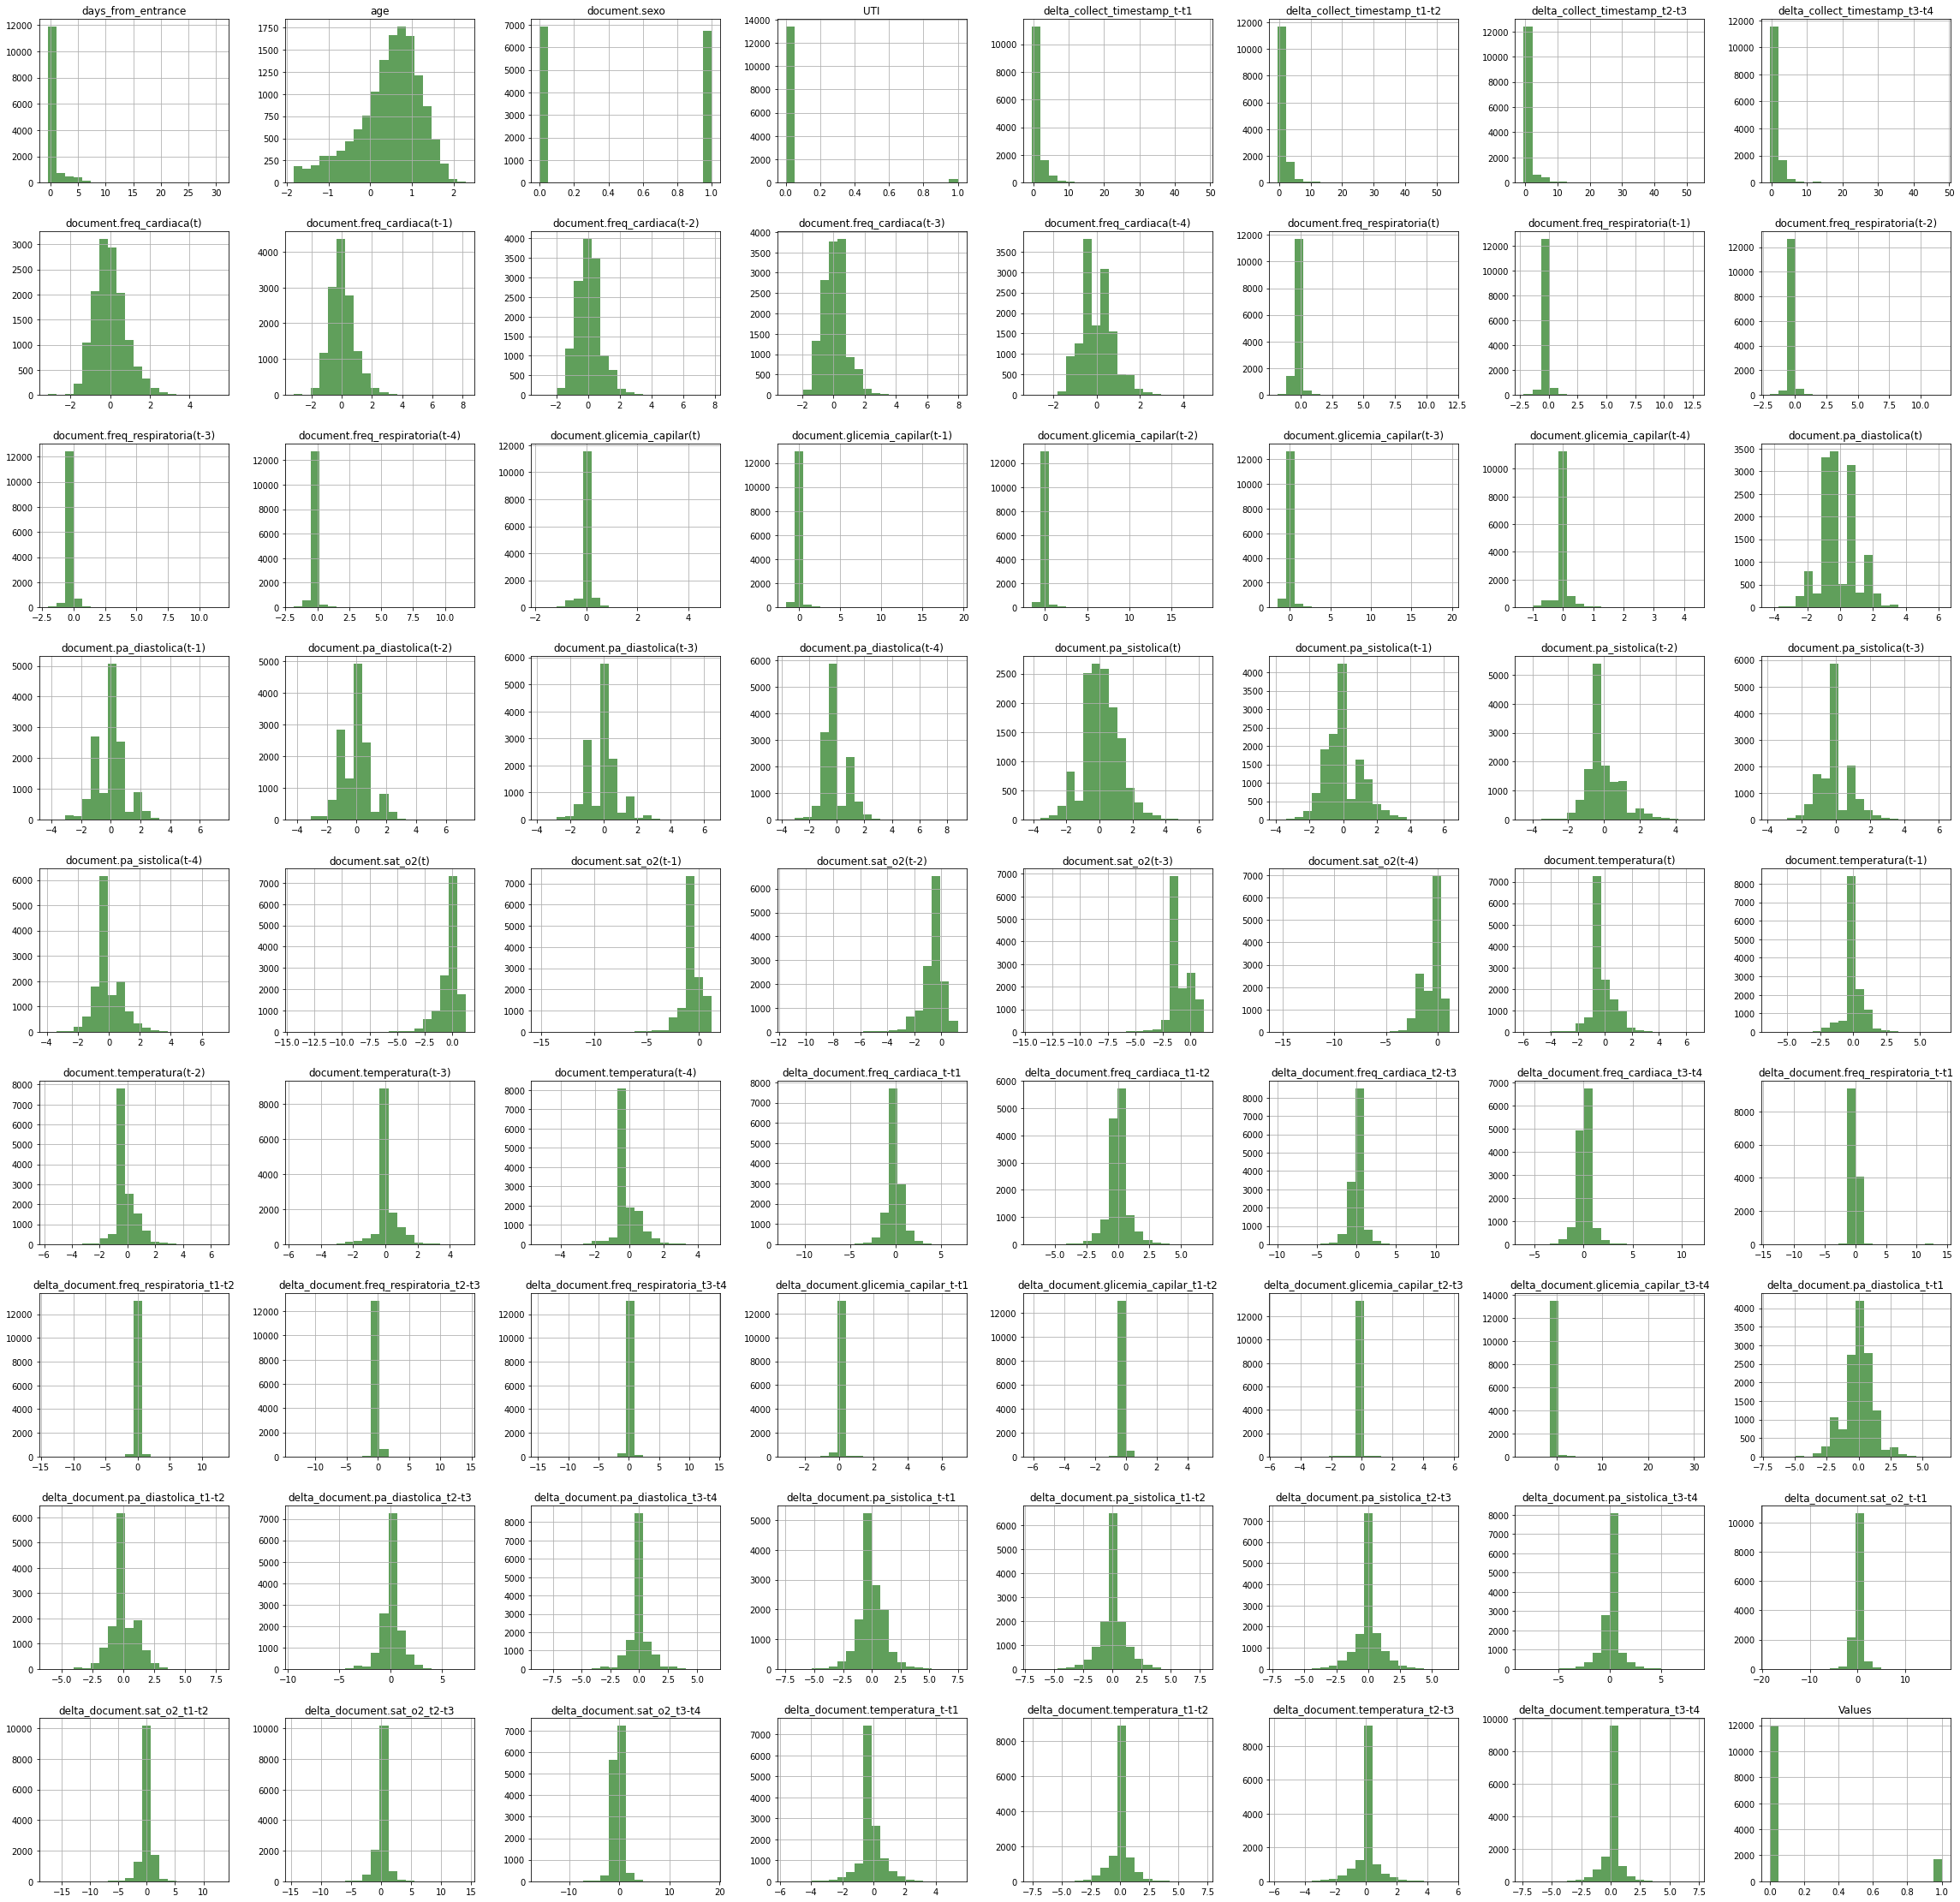

In [5]:

dataset.hist(figsize=(40,40),bins = 20, color="#107009AA")
plt.title("Values")
plt.show()

['days_from_entrance']


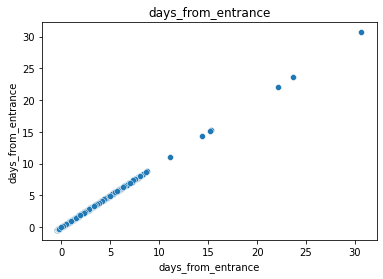

In [40]:
temporal_features = [feat for feat in dataset if "days_from_entrance" in feat or "delta_collect_timestamp_t-t1' 'delta_collect_timestamp_t1-t2" in feat]
print(temporal_features)
for feature in temporal_features:
    sns.scatterplot(x=feature,y="days_from_entrance",data=dataset)
    plt.title(feature)
    plt.show()

## Setup Expetiments

In [6]:
X = dataset.drop(["outcome"], axis = 1)
Y = dataset["outcome"]

In [7]:
kfold = KFold(n_splits=10, random_state=7, shuffle=True)

classifiers = {
    'XGBoost' : XGBClassifier(learning_rate=0.1, n_estimators=100,random_state=7, tree_method='gpu_hist'),
    'LogReg': LogisticRegression(solver='liblinear', multi_class='ovr'),
    'D.Tree': DecisionTreeClassifier(),
    'RForest': RandomForestClassifier(n_estimators = 50),
    'CatBoos': CatBoostClassifier(learning_rate=0.1,n_estimators=100,random_state=7,task_type='GPU',verbose = False),
    'Naive': GaussianNB(),
    'Light': lgb.LGBMClassifier()
}

In [33]:
#print(classifiers)

## Run Basic Experiments

In [8]:
for c in classifiers:
  start = time.time()
  model = classifiers[c]
  scores = cross_val_score(model, X, Y, cv=kfold, scoring='roc_auc')
  scores_f1 = cross_val_score(model, X, Y, cv=kfold, scoring='f1')
  print (c + '\t', round(scores.mean(),4), '(' + str(round(scores_f1.mean(),4)) + ')', round(time.time() - start,2), 's')

XGBoost	 nan (nan) 0.37 s
LogReg	 0.8783 (0.5129) 11.03 s
D.Tree	 0.6959 (0.4635) 11.89 s
RForest	 0.8858 (0.515) 41.39 s
CatBoos	 nan (nan) 0.19 s
Naive	 0.7854 (0.456) 0.32 s
Light	 0.9063 (0.5939) 8.23 s


## Cross Validation by Windowing

In [9]:
cols = ['age', 'document.sexo', 'UTI', 'days_from_entrance']
t_cols = [c for c in dataset.columns if '4)' in c and (not 'time' in c)]

for i in [4,3,2,1,0]:
  
  if i == 4: cols.extend(t_cols)
  if i == 0:
    tN_cols = [c for c in dataset.columns if ('t)' in c or '_t-' in c) and (not 'time' in c)]
    cols.extend(tN_cols)
  else: 
    tN_cols = [c for c in dataset.columns if ('t-'+str(i) in c or '_t'+str(i) in c) and (not 'time' in c)]
    cols.extend(tN_cols)

  cols = list(set(cols))
  print('Number of Columns:', len(cols), 'Exam(s):', 5-i)
  print(cols)

  X_W = dataset[cols]
  Y_W = dataset["outcome"]

  for c in classifiers:
    start = time.time()
    model = classifiers[c]
    scores = cross_val_score(model, X_W, Y_W, cv=kfold, scoring='roc_auc')
    print ('\t' + c + '\t', round(scores.mean(),4), '(+-' + str(round(scores.std(),4)) + ')', round(time.time() - start,2), 's')

Number of Columns: 11 Exam(s): 1
['document.sat_o2(t-4)', 'document.pa_sistolica(t-4)', 'document.freq_cardiaca(t-4)', 'document.sexo', 'document.pa_diastolica(t-4)', 'document.freq_respiratoria(t-4)', 'document.glicemia_capilar(t-4)', 'document.temperatura(t-4)', 'age', 'days_from_entrance', 'UTI']
	XGBoost	 nan (+-nan) 0.09 s
	LogReg	 0.8045 (+-0.015) 0.37 s
	D.Tree	 0.6352 (+-0.0122) 0.54 s
	RForest	 0.8115 (+-0.0154) 6.3 s
	CatBoos	 nan (+-nan) 0.05 s
	Naive	 0.7696 (+-0.0138) 0.07 s
	Light	 0.8406 (+-0.0085) 2.48 s
Number of Columns: 25 Exam(s): 2
['delta_document.pa_sistolica_t3-t4', 'document.sat_o2(t-4)', 'document.freq_cardiaca(t-3)', 'document.freq_respiratoria(t-4)', 'delta_document.temperatura_t3-t4', 'document.glicemia_capilar(t-4)', 'document.sat_o2(t-3)', 'delta_document.freq_respiratoria_t3-t4', 'delta_document.pa_diastolica_t3-t4', 'document.temperatura(t-3)', 'document.pa_sistolica(t-3)', 'document.glicemia_capilar(t-3)', 'delta_document.freq_cardiaca_t3-t4', 'days_fr